### Домашняя работа "Улучшение качества модели"

In [1]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import uniform

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
df = data.copy()

Содержит информацию о жилье в Бостоне, собранную бюро переписи населения США.

- CRIM - уровень преступности на душу населения
- ZN - доля земли под жилую застройку,
- INDUS - доля акров, не относящихся к розничной торговле.
- CHAS - фиктивная переменная реки Чарльз (1, если участок ограничивает реку; 0 в противном случае)
- NOX - концентрация оксидов азота 
- RM - среднее количество комнат в доме
- AGE - доля занимаемых владельцами единиц, построенных до 1940 г.
- DIS - взвешенное расстояние до пяти бостонских центров занятости
- RAD - индекс доступности радиальных автомобильных дорог
- TAX - полная ставка налога на имущество за 10 000 долларов США.
- PTRATIO - соотношение учеников и учителей по городам
- B - 1000 (Bk - 0,63) ^ 2, где Bk - доля афроамериканцев по городам
- LSTAT - % более населения низкого соц статуса
- MEDV - Средняя стоимость домов в 1000 долларов

In [4]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Отсутствуют пропущенные значения

In [5]:
data.describe().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.22,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


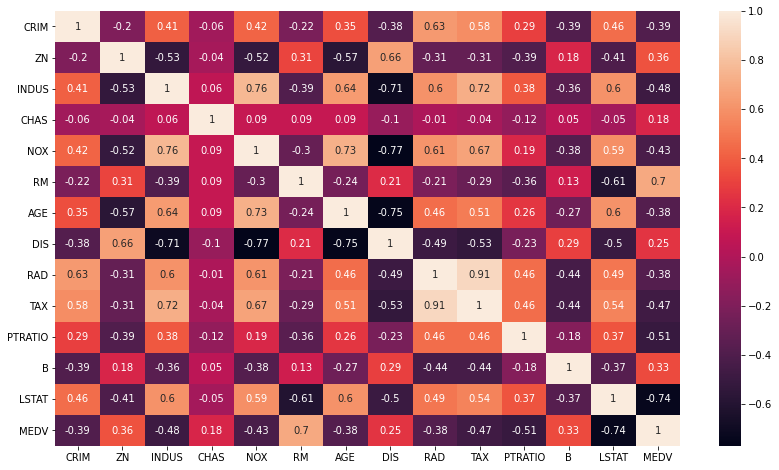

In [6]:
rcParams['figure.figsize'] = 14,8

correlation_matrix = data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

Посмотрев на матрицу корреляции, мы можем увидеть, что RM имеет сильную положительную корреляцию с MEDV (0,7), тогда как LSTAT имеет высокую отрицательную корреляцию с MEDV (-0,74) 

Важным моментом при выборе признаков для модели линейной регрессии является проверка на мультиколинейность. Характеристики RAD , TAX имеют соотношение 0,91 . Эти пары функций сильно коррелированы друг с другом. Это может повлиять на модель. То же самое касается функций DIS и AGE, у которых соотношение составляет -0,75 .

Распределение цен на жилье по LTSTAT и RM


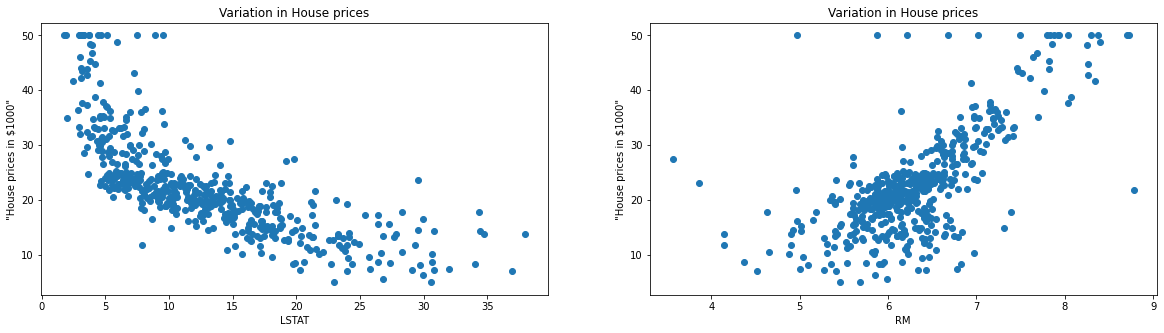

In [7]:
plt.figure(figsize=(20, 5))

print('{}'.format('Распределение цен на жилье по LTSTAT и RM'))

features = ['LSTAT', 'RM']
target = df['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title("Variation in House prices")
    plt.xlabel(col)
    plt.ylabel('"House prices in $1000"')


#### Проверим данные на выбросы

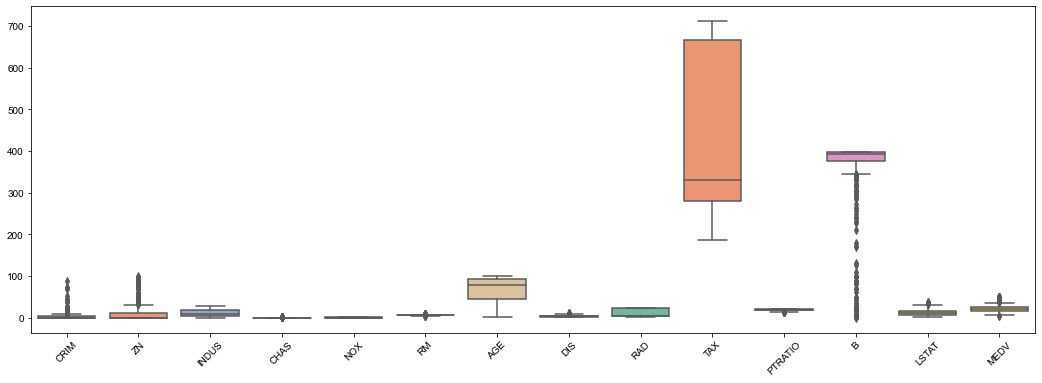

In [8]:
rcParams['figure.figsize'] = 18,6

plt.xticks(rotation=45)
sns.set_theme(style="darkgrid")

sns.boxplot(data = df, palette="Set2", orient = 'v');

In [9]:
def outliers(data):
    q25, q75 =data.quantile([.25, .75])
    iqr = q75-q25
    return data.between(q25-1.5*iqr, q75+1.5*iqr)

In [10]:
outlier_threshold  = 0.1
to_exclude_outlier_cols = []
print('{:<8}  {}'.format('Признак', 'Выброс'))
for col in df.drop('MEDV', 1).columns:
    outlier_share = 1- outliers(df[col]).mean()    
    print('{:<8}  - {:.2%}'.format(col, outlier_share))
    if outlier_share < outlier_threshold:
        to_exclude_outlier_cols.append(col)

Признак   Выброс
CRIM      - 13.04%
ZN        - 13.44%
INDUS     - 0.00%
CHAS      - 6.92%
NOX       - 0.00%
RM        - 5.93%
AGE       - 0.00%
DIS       - 0.99%
RAD       - 0.00%
TAX       - 0.00%
PTRATIO   - 2.96%
B         - 15.22%
LSTAT     - 1.38%


In [11]:
df.shape

(506, 14)

#### Удалим выбросы

In [12]:
df = df[df[to_exclude_outlier_cols].fillna(0).apply(outliers).all(1)]

In [13]:
df.shape

(424, 14)

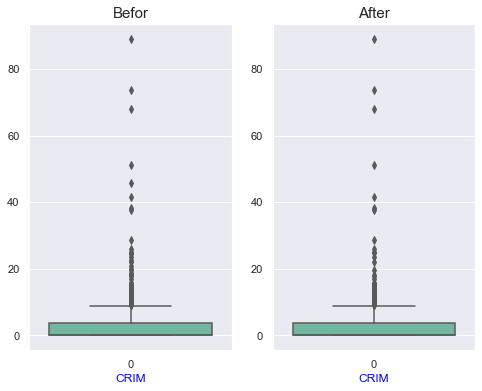

In [14]:
rcParams['figure.figsize'] = 8,6

plt.subplot(1, 2, 1)
plt.title('Befor', fontsize=15)
sns.boxplot(data = data['CRIM'], palette="Set2", orient = 'v');
plt.xlabel('CRIM', fontsize=12, color='blue');

plt.subplot(1, 2, 2)
plt.title('After', fontsize=15)
sns.boxplot(data = df['CRIM'], palette="Set2", orient = 'v');
plt.xlabel('CRIM', fontsize=12, color='blue');

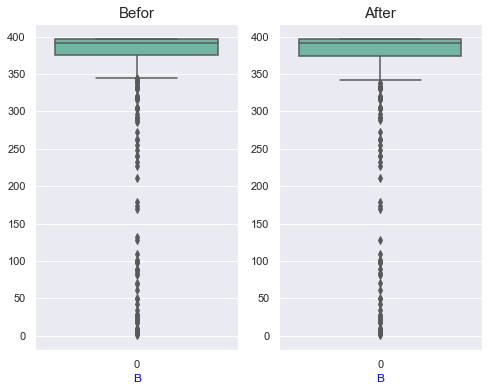

In [15]:
rcParams['figure.figsize'] = 8,6

plt.subplot(1, 2, 1)
plt.title('Befor', fontsize=15)
sns.boxplot(data = data['B'], palette="Set2", orient = 'v');
plt.xlabel('B', fontsize=12, color='blue');

plt.subplot(1, 2, 2)
plt.title('After', fontsize=15)
sns.boxplot(data = df['B'], palette="Set2", orient = 'v');
plt.xlabel('B', fontsize=12, color='blue');

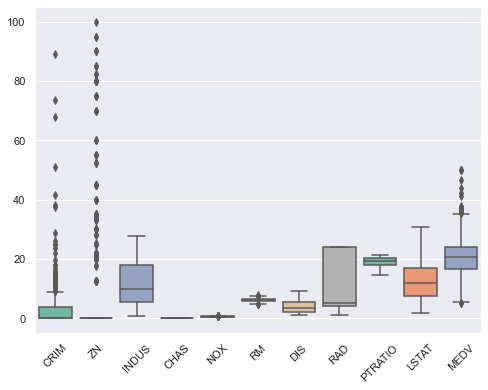

In [16]:
plt.xticks(rotation=45)
rcParams['figure.figsize'] = 20,6
sns.set_theme(style="darkgrid")
sns.boxplot(data = df.drop(['TAX', 'B', 'AGE'],1), palette="Set2", orient = 'v');

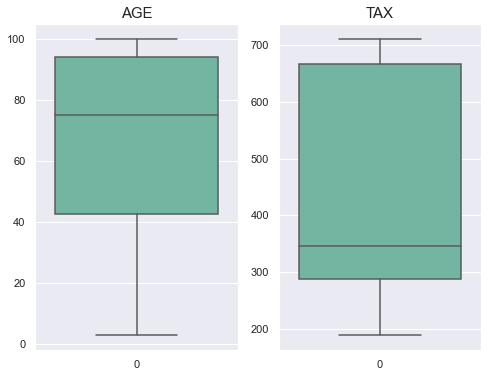

In [17]:
rcParams['figure.figsize'] = 8,6

plt.subplot(1, 2, 1)
plt.title('AGE', fontsize=15)
sns.boxplot(data = df['AGE'], palette="Set2", orient = 'v');

plt.subplot(1, 2, 2)
plt.title('TAX', fontsize=15)
sns.boxplot(data = df['TAX'], palette="Set2", orient = 'v');

In [18]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


### Отбор признаков

In [22]:
sc = StandardScaler()
sc.fit(df.drop('MEDV', 1))
data_std = sc.transform(df.drop('MEDV', 1))

#### ElasticNet

In [23]:
from sklearn.linear_model import ElasticNet

Elastic = ElasticNet(alpha=0.7, l1_ratio=0.8, fit_intercept=True, precompute=False, max_iter=1000, 
           tol=0.0001, warm_start=False, positive=False, random_state=0, selection='cyclic')

#### RepeatedKFold

Т.к. наш target является 'continuous' используем RepeatedKFold

In [24]:
from sklearn.utils.multiclass import type_of_target
type_of_target(df['MEDV'].values)

'continuous'

In [25]:
from sklearn.model_selection import RepeatedKFold

nsplits, nrepeats = 10, 2
nfolds = nsplits*nrepeats
rskf = RepeatedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state = 0)

Функция для отбора признаков

In [28]:
def _select_features(clf, _xtr, _ytr, cv, metric):
    
    '''
    Отбирает признаки 
    
    Параметры:
        1) clf - модель
        2) _xtr - признаки
        3) _ytr - таргет
        4) cv - схема валидации
    
    Возвращает:
        лучшее значение метрики, лучший набор признаков
    '''
    
    xtr, ytr = np.array(_xtr), np.array(_ytr)
#     xtr = _xtr
#     ytr = _ytr
    # валидируем каждый признак
    scores = []
    for i in range(xtr.shape[1]):
        scores.append(cross_validate(clf, xtr[:, i].reshape(-1,1),\
                                     ytr, scoring =metric, cv = cv)['test_score'].mean())
    # сортируем индивидуальные скоры в порядке убывания
    order = np.argsort(scores)[::-1]
    # лучший скор, лучшие признаки, признаки для проверки, счетчик ранней остановки
    best_score, best_features, feature_i, to_drop = .4, [], [],[]
    # по признакам в порядке убывания индивидуальных скоров
    for i in order:
        # добавляем признак в список лучших
        current_features = best_features+[i]
        # считаем валидацю
        mean_score = cross_validate(clf, xtr[:, current_features],\
                                     ytr, scoring =metric, cv = cv)['test_score'].mean()
        # если есть улучшение
        if mean_score > best_score:
            # обновляем лучший скор
            best_score = mean_score
            # обновляем лучшие признаки
            best_features = current_features 
            # добавляем лучшие признаки 
            feature_i.append(i)
        # если улчшения нет
        else:
            # добавляем признак в кандидаты на удаление
            to_drop.append(i)
            
            
    # списки на удаление признаков ДО и ПОСЛЕ отбора
    to_drop_before = to_drop
    to_drop_after = []
    # запускаем бесконечный цикл
    while True:
        # добавляем последовательно признаки из кандидатов на удаление
        for i in to_drop_before:
            current_features = best_features+[i]
            mean_score = cross_validate(clf, xtr[:, current_features],\
                                     ytr, scoring =metric, cv = cv)['test_score'].mean()
            # если есть улучшение скора
            if mean_score > best_score:
                # обновляем лучший скор
                best_score = mean_score
                # обновляем лучшие признаки
                best_features = current_features            
            else:
                # добавляем признак в кандидаты на удаление ПОСЛЕ
                to_drop_after.append(i)
        # если списки ДО и ПОСЛЕ отличаются меньше, чем на 5 признаков 
        if len(to_drop_before) == len(to_drop_after):
            # останавливаем отбор
            break            
        else:
            # ДО --> ПОСЛЕ, ПОСЛЕ - пустой
            to_drop_before = to_drop_after
            to_drop_after = []
            
            
    return (best_score, best_features, feature_i)

In [30]:
%%time

results_L = []
# используем метрику
for metric in ['r2']:
    # отбираем признаки
    best_score, best_features, feature_i = _select_features(Elastic, data_std, df['MEDV'], cv = rskf, metric=metric)    
    results_L.append((metric, best_score, best_features))
results_L = np.array(results_L)[np.argsort([r[1] for r in results_L])[::-1]]

CPU times: user 724 ms, sys: 5.68 ms, total: 729 ms
Wall time: 729 ms


In [40]:
print('{:<10} | {} | {} | {}'.format('метрика', 'валидация', 'отобранные признаки', 'всего признаков'))
print('--------------------------------------------------------------')
for el in results_L:
    print('{:<10} | {:<9.5f} | {:<19} | {}'.format(el[0], el[1], len(el[2]), df.drop('MEDV', 1).shape[1]))

метрика    | валидация | отобранные признаки | всего признаков
--------------------------------------------------------------
r2         | 0.64723   | 7                   | 13


Мы отобрали 7 признаков с помощью перекрестной валидации

#### Теперь попробуем отобрать с помощью DecisionTreeRegressor

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state = 0,
                               max_depth=3, min_samples_leaf=5)
tree.fit(data_std, df['MEDV'])

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=0)

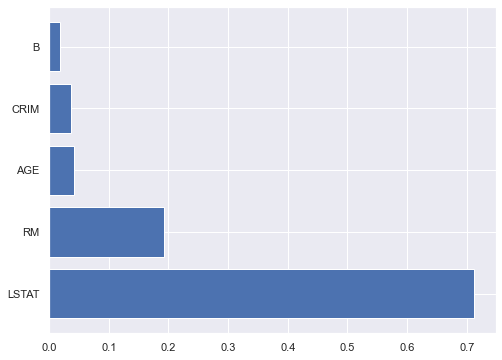

In [42]:
imp = pd.Series(tree.feature_importances_)
imp = imp.sort_values(ascending=False)

# Выберем порог значений для отбора признаков
Threshold = 0.001

amount = sum(np.where(imp.values > Threshold, 1, 0))
imp = imp[:amount]
    
plt.barh(np.arange(len(imp)), imp.values)
plt.yticks(np.arange(len(imp.index.values)), df.iloc[:, imp.index.values].columns);

In [44]:
feature_col = df.iloc[:, imp[:amount].index.values].columns
print(f'DecisionTreeRegressor отобрал {amount} признаков')

DecisionTreeRegressor отобрал 5 признаков


#### Сравним два списка отобранных списка 

In [45]:
feature_7 = df.iloc[:, feature_i].columns
feature_5 = df.iloc[:, imp.index.values].columns

### GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

### Models

In [49]:
from sklearn.svm import LinearSVR

svm = LinearSVR(epsilon = 0.0 , tol = 0.1 , C = 0.8 , loss = 'squared_epsilon_insensitive',
                intercept_scaling = 0.3 , random_state = 0, max_iter = 1000)

[LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [50]:
from sklearn.neighbors import KNeighborsRegressor

KNeighbors = KNeighborsRegressor(n_neighbors=5, weights='uniform', 
                                 algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                                 metric_params=None, n_jobs=-1)

[KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state = 0,
                               max_depth=3, min_samples_leaf=5)

[DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [52]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, 
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [53]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1, fit_intercept=True, normalize=False, 
      copy_X=True, max_iter=100, tol=0.001, solver='auto', random_state=None)

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [54]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1, positive=False)

[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [55]:
from sklearn.linear_model import ARDRegression

Bayesian = ARDRegression(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, 
              lambda_2=1e-06, compute_score=False, threshold_lambda=10000.0, fit_intercept=True,
              normalize=False, copy_X=True, verbose=False)

[ARDRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html)

### Params

In [56]:
models=[
      {'name':'svm',"model":LinearSVR(), 'params':{'epsilon':[0.1,0.2,0.3],'C':np.arange(0, 1, 0.1),'random_state':np.arange(0, 100, 10)}},  
      {'name':'KNeighbors',"model": KNeighborsRegressor(), 'params':{'n_neighbors':list(range(1,20)),'weights': ['uniform', 'distance'], 'p':[1,2,3], 'metric':['minkowski', 'euclidean', 'manhattan']}},
      {'name':'tree',"model": DecisionTreeRegressor(), 'params':{'criterion':['mse', 'friedman_mse'], 'max_depth':np.arange(2, 10, 1),'random_state':np.arange(0, 100, 10)}},
      {'name':'lasso',"model": Lasso(), 'params':{'alpha':[1e-6, 1e-5, 1e-3, 1e-1], 'tol':[1e-3, 1e-2, 1e-1],'random_state':np.arange(0, 100, 10)}},
      {'name':'ridge',"model": Ridge(), 'params':{'alpha': [1e-6, 1e-5, 1e-3, 1e-1], 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg']}},
      {'name':'lr',"model": LinearRegression(), 'params':{'fit_intercept':[True, False]}},
      {'name':'Bayesian',"model": ARDRegression(), 'params':{'n_iter':np.arange(100, 500, 100), 'tol':[1e-3, 1e-2, 1e-1], 'alpha_1':[1e-6, 1e-5, 1e-3, 1e-1], 'alpha_2':[1e-6, 1e-5, 1e-3, 1e-1], 
                                                                'lambda_1':[1e-6, 1e-5, 1e-3, 1e-1],'lambda_2':[1e-6, 1e-5, 1e-3, 1e-1]}}
]

In [57]:
%%time

res7=[]
res5=[]

for feature in [feature_7, feature_5]:
    
    X_train, X_valid, y_train, y_valid = train_test_split(df[feature], df['MEDV'], test_size=0.2)

    # Инициализируем стандартизацию
    sc = StandardScaler()
    
    # Стандартизируем тренировочные значения      
    X_train = sc.fit_transform(X_train)
    X_valid = sc.fit_transform(X_valid)
    
    if len(feature) == 7:
        for m in  models:
            res7.append((m['name'], GridSearchCV(m['model'], m['params'], cv=10, scoring='r2').fit(X_train, y_train)))
    else:
        for m in  models:
            res5.append((m['name'], GridSearchCV(m['model'], m['params'], cv=10, scoring='r2').fit(X_train, y_train))) 

CPU times: user 3min 59s, sys: 10.8 s, total: 4min 10s
Wall time: 2min 54s


In [58]:
print('{:<10} | {} '.format('модель', 'валидация'))
print('-----------------------')
for r in res7:
    print('{:<10} | {:<9.5f} '.format(r[0], r[1].best_score_.round(5)))

модель     | валидация 
-----------------------
svm        | 0.63796   
KNeighbors | 0.76255   
tree       | 0.65789   
lasso      | 0.65645   
ridge      | 0.65166   
lr         | 0.65154   
Bayesian   | 0.65679   


In [59]:
print('{:<10} | {} '.format('модель', 'валидация'))
print('-----------------------')
for r in res5:
    print('{:<10} | {:<9.5f} '.format(r[0], r[1].best_score_.round(5)))

модель     | валидация 
-----------------------
svm        | 0.64272   
KNeighbors | 0.75246   
tree       | 0.66720   
lasso      | 0.66344   
ridge      | 0.66343   
lr         | 0.66341   
Bayesian   | 0.66351   


#### Наилучшая метрика KNeighbors для 7 отобранных признаков

### RandomizedSearchCV

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(df[feature_7], df['MEDV'], test_size=0.2)

X_train = sc.fit_transform(X_train)
X_valid = sc.fit_transform(X_valid)

In [62]:
%%time

res=[]
for m in  models:
    res.append((m['name'], RandomizedSearchCV(m['model'], m['params'], cv=10, scoring='r2').fit(X_train, y_train)))

CPU times: user 1.22 s, sys: 37.6 ms, total: 1.25 s
Wall time: 1.03 s


In [63]:
print('{:<10} | {} '.format('модель', 'валидация'))
print('-----------------------')
for r in res5:
    print('{:<10} | {:<9.5f} '.format(r[0], r[1].best_score_.round(5)))

модель     | валидация 
-----------------------
svm        | 0.64272   
KNeighbors | 0.75246   
tree       | 0.66720   
lasso      | 0.66344   
ridge      | 0.66343   
lr         | 0.66341   
Bayesian   | 0.66351   


RandomizedSearchCV справился быстрее, но посчитал немного не точно